In [1]:
import numpy as np
import matplotlib.pyplot as plt
#from random import choice
from matplotlib.image import BboxImage
from matplotlib.transforms import Bbox, TransformedBbox
from skimage.transform import resize
from scipy.stats import norm
import tensorflow as tf
import sys
sys.path.append('..')
from utils import *
#from tensorflow.contrib import layers

### Load Data list names
Rather than load all the data into ram. We just load the names of all the images and annotations. Shuffle the names and partition them into train and test sets. Then we only load the images/annotations when neeed.

In [2]:
base_dir      = '../data/clr_120_160/'
image_dir     = base_dir + 'images/'
anno_dir      = base_dir + 'annotations/'
train_path = '../data/evened_train.txt'
test_path  = '../data/evened_test.txt'

raw_train = load_dataset(train_path)
raw_test = load_dataset(test_path)

# Bin Steering Data
The steering and throttle annotations come in as numbers between 0 and 1023. So our network does not need to have 1024 output neurons we partition the data into bins.

ie:

if we had data consisting of numbers 0-9 :



`data = [1,4,5,0,9,8,5,4,3,2,5,6,7]`

and we binned in lost of 2 the our data would look like this:
```
# bins:  0   1   2   3   4
# nums: 01, 23, 45, 67, 89

binned = [0,2,2,0,4,4,2,2,1,1,2,3,3]
```

In [3]:
NUM_BINS = 15
# train = bin_steering_annos(raw_train, NUM_BINS)
# test = bin_steering_annos(raw_test, NUM_BINS)
# for i,a in train[100:110]:
#     print(a)

## Data Generator

This is what we're going to use to take care of loading our actual images and annotations as we need them. When initalized it shuffles the `data_names` then calling the `get_next_bacth` function returns a tuple of `(images, annotations)`. Calling the `still_has_data`function returns a boolean indicating wether or not all the data has been used up.

In [4]:
from behavoural_data_generator import DataGenerator

In [5]:
my_data=DataGenerator(batch_size=10, 
                      data_set=raw_train,
                      image_dir=image_dir,
                      anno_dir=anno_dir, 
                      num_bins=NUM_BINS)


Below we plot a histogram of the data we're going to use to train the model. Just to make sure there is not a crazy bias in the data.

*eg: if the video containing the data has the car parked for a few seconds at the beginning and end of a run you may get a large spike in the data around 'go strait'*

In [6]:
annos = my_data.all_annotations()
plt.hist(annos['steering'])

NameError: name 'os' is not defined

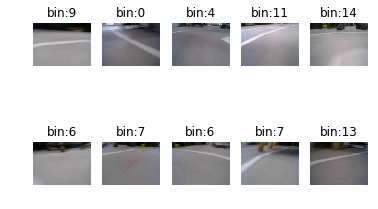

In [7]:
images, annos = my_data.get_next_batch()
for i, (im, st, th) in enumerate(zip(images[:10], annos['steering'][:10], annos['throttle'][:10])):
    plot = i+1
    plt.subplot(2,5,plot)
    if np.shape(images)[3] == 1:
        plt.imshow(im[:,:,0])
    else:
        plt.imshow(im[:,:,])
    plt.axis('off')
    angle = st
    plt.title("bin:{}".format(int(angle)))


### Some hyperparams

In [8]:
from show_graph import show_graph
from tf_donkey import Model
classes = [x for x in range(NUM_BINS)]
car_brain = Model(in_shape=[120,160,3], classes=classes)

in_shape:           [120, 160, 3]
classes:             [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


### Train and Test Generators

In [9]:
train_gen=DataGenerator(batch_size=50, 
                      data_set=raw_train,
                      image_dir=image_dir,
                      anno_dir=anno_dir, 
                      num_bins=NUM_BINS)

test_gen=DataGenerator(batch_size=50, 
                      data_set=raw_test,
                      image_dir=image_dir,
                      anno_dir=anno_dir, 
                      num_bins=NUM_BINS)

# !!!!!!!!!!!!!!!! --- Run The Model --- !!!!!!!!!!!!!!!!

Testing: 100%|██████████| 41/41 [00:14<00:00,  2.89it/s]


Test Loss: 2.372
--------------------------------------------------
Model saved at ./__z__/ep_1_loss_2.37_bins_15.ckpt
Train: [2.6729405]
Test:  [2.372179]
Done, final best loss: 2.37


'./__z__/ep_1_loss_2.37_bins_15.ckpt'

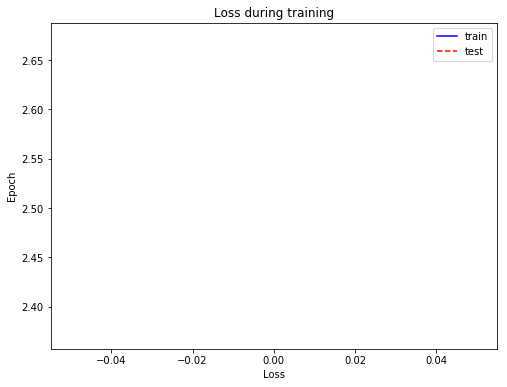

In [10]:
epochs = 1
batch_size = 50
learning_rate = 0.001
car_brain.Train(train_gen=train_gen,
               test_gen=test_gen,
               save_dir = "./__z__",
               epochs=epochs)
               



In [ ]:
tr_loss, te_loss, te_acc = car_brain.TrainingResults()
plt.plot(te_loss)
fig = plt.gcf()
fig.savefig('tf_donkey_clr_15bins.png', dpi=100)

### Perform Prediction on images using ONLY test data


In [ ]:
test_gen = DataGenerator(batch_size=10, 
                      data_set=test[:100],
                      image_dir=image_dir,
                      anno_dir=anno_dir, 
                      num_bins=NUM_BINS)
images, annos = test_gen.get_next_batch()
ckpt = "ep_18-step_161-loss_1.05.ckpt"
probs, preds = car_brain.Predict(images, ckpt)
pred_angles = car_brain.ExpectedBinToDeg(preds)

In [ ]:
bins = list(range(1,NUM_BINS+1))
y_pos = np.arange(8)
print("len: ", len(annos))
for i, (im, an, prob, pred) in enumerate(zip(images, annos, probs, preds)):
    plot = i + 1
    plt.subplot(2,10,plot)
    plt.xticks([])    
    plt.yticks([])
    plt.title("{}".format(int(an)))
    if np.shape(images)[3] == 1:
        plt.imshow(im[:,:,0])
    else:
        plt.imshow(im[:,:,])
    
    plot += 10
    plt.subplot(2,10,plot)
    plt.bar(bins, prob)
    plt.axis([0, 9, 0, 1.])
    plt.yticks([],[])
    plt.title("{:.2}".format(pred))
    
plt.subplot(2,10,11)
plt.xlabel("Class")
plt.ylabel("Prob")
#plt.yticks([0.,0.2, 0.4, 0.6, 0.8, 1.0])

In [ ]:
all_data_sequential = load_data("../data/all_data_sequential.txt")
all_img_paths = [f"../data/color_120_160_annotated/images/{ele[0]}.jpg" for ele in all_data_sequential]
all_data_sequential_binned = bin_steering_annos(all_data_sequential, NUM_BINS)
# all_images    = load_images(all_img_paths)

In [ ]:
all_gen = DataGenerator(batch_size=50, 
                      data_set=all_data_sequential_binned,
                      image_dir=image_dir,
                      anno_dir=anno_dir, 
                      num_bins=NUM_BINS,
                      shuffle=False)
annotations = [ele[1] for ele in all_data_sequential]
predictions = list()
annotations_binned = list()
#ckpt = "ep_17-step_161-loss_0.799.ckpt"
with tf.Session() as sess:
    car_brain.saver.restore(sess,ckpt)
    t = trange(all_gen.steps_per_epoch)
    for step in t:
        images, annos = all_gen.get_next_batch()
        probs, preds = sess.run([car_brain.steering, car_brain.prediction], feed_dict={car_brain.x:images, car_brain.training: False})
        pred_angles = car_brain.ExpectedBinToDeg(preds)
        predictions.extend(preds)
        annotations_binned.extend(annos)

In [ ]:
start = 9500
end   = 11000
#end   = start+len(preds_converted)
preds_converted = [int(p*(1024/NUM_BINS)) for p in predictions]
# labels = [ele[1] for ele in all_data_sequential]
x_ax = range(len(preds_converted[start:end]))
# print(np.shape(labels[:-46]))
print(np.shape(preds_converted))
fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
plt.plot(x_ax, preds_converted[start:end], "-r", label="predictions")
plt.plot(x_ax, annotations[start:end], "-g", label="annotations")
plt.legend()
fig.savefig('tf_jp_clr_12500-14000_15bins.png', dpi=100)

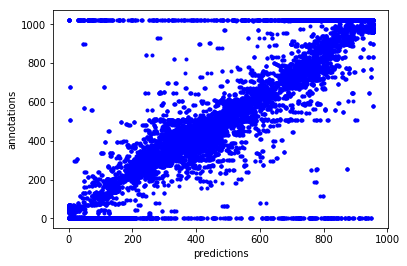

In [39]:
plt.plot(preds_converted, annotations[:-46], 'b.')
plt.xlabel("predictions")
plt.ylabel("annotations")
fig = plt.gcf()
fig.savefig('tf_jp_clr_15bins_scatter.png', dpi=100)

hight: 5837
low  : 50
rest  : 13863
791


In [ ]:
#print(all_img_paths[0].split('/')[-1].split('.')[0])
for a, img_pth in zip(angles, all_img_paths):
    im = img_pth.split('/')[-1].split('.')[0]
    with open("./to_make_movie.txt", 'a') as file:
        file.write("{}, {}\n".format(im, a[0:0]))

In [ ]:
from annotate_video_inplace import *
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess,'./ep_19-step_50-loss_0.5418351888656616.ckpt')
    
    video_inference(sess, x, prediction, training, "/home/jp/Documents/FYP/ml/data/videoplayback.mp4", "/home/jp/Desktop/video_infer")

Closed


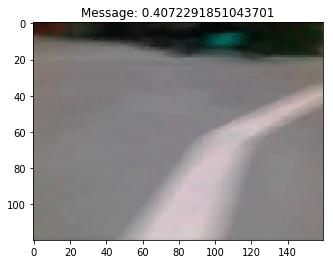

In [25]:
%matplotlib inline
from IPython import display
import socket
import time
import cv2

host = "192.168.0.135"
port = 5555
s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
s.connect((host, port))

ckpt = "ep_18-step_161-loss_1.05.ckpt"
video_path = "/home/jp/Documents/FYP/ml/data/videoplayback.mp4"
if os.path.exists(video_path):
    with tf.Session() as sess:
        car_brain.saver.restore(sess,ckpt)
        vidcap = cv2.VideoCapture(video_path)
        success, image = vidcap.read()
        if success:
            try: 
                count = 0
                while success:
                    if count % 10 ==0:
                        image = image[40:,:]
                        orig_h      = image.shape[0]
                        orig_w      = image.shape[1]
                        x_scale     = 160. / 640.
                        y_scale     = 120. / 320.
                        img = cv2.resize(image, None, fx=x_scale, fy=y_scale)
                        plt.imshow(img)

                        display.clear_output(wait=True)
                        display.display(pl.gcf())
                        img = np.expand_dims(img, axis=0)
                        pred = sess.run(car_brain.prediction, feed_dict={car_brain.x:img, car_brain.training: False})
                        pred_angle = car_brain.ExpectedBinToDeg(pred, steering_range_deg=80)
                        pred_angle = pred_angle[0]/40
                        message = f"{pred_angle}"
                        s.sendall(str.encode(message))
                        plt.title(f"Message: {message}")
                    success, image = vidcap.read()
            except KeyboardInterrupt:
                    s.close()
                    print("Closed")


In [12]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import label_binarize
import numpy as np

probs   = [[0.7, 0.1, 0.2], [0.1, 0.7, 0.2], [0.1, 0.2, 0.7],
           [0.7, 0.1, 0.2], [0.1, 0.7, 0.2], [0.1, 0.2, 0.7],
           [0.7, 0.1, 0.2], [0.1, 0.7, 0.2], [0.1, 0.2, 0.7]]
probs = np.array(probs)
annos   =  [0,0,2,1,2,0,0,2,1]
classes =  [0,1,2]
y       = label_binarize(annos, classes=classes)
precision = dict()
recall = dict()
thresh = dict()
average_precision = dict()
for c in classes:
    # 2Darray[:,c] syntax returns the column at idx c (ie: per class prob and label) 
    precision[c], recall[c], thresh[c] = precision_recall_curve( y[:,c], probs[:,c])
    average_precision[c]       = average_precision_score(y[:,c], probs[:,c])

In [13]:
thresh[0]

array([0.1, 0.7])

In [10]:
eval_gen = test_gen
ckpt = "ep_18-step_161-loss_1.05.ckpt"
precision, recall, thresh, average_precision = car_brain.Evaluate(eval_gen, ckpt)


classes: 15
INFO:tensorflow:Restoring parameters from ep_18-step_161-loss_1.05.ckpt


Evaluating your face!: 100%|██████████| 41/41 [00:10<00:00,  3.73it/s]

Average precision score, micro-averaged over all classes: 0.73


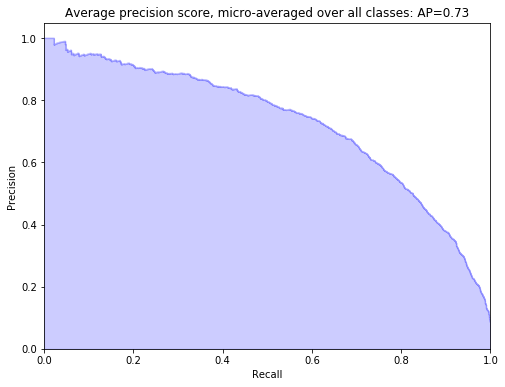

In [29]:
fig = plt.figure(figsize=(8,6))
plt.step(recall['micro'], precision['micro'], color='b', alpha=0.2,
         where='post')
plt.fill_between(recall["micro"], precision["micro"], step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))
plt.savefig(f"fig_{i}")

(0.0, 1.0)

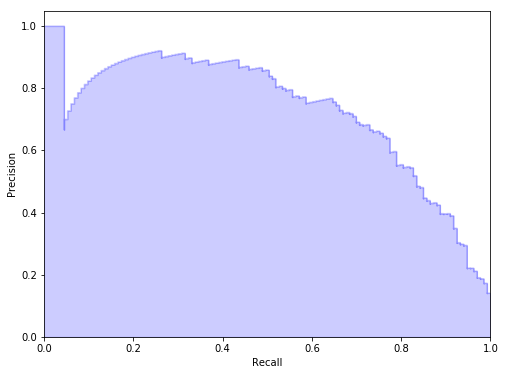

In [38]:
class_idx = 3
fig = plt.figure(figsize=(8,6))
plt.step(recall[class_idx], precision[class_idx], color='b', alpha=0.2,
         where='post')
plt.fill_between(recall[class_idx], precision[class_idx], step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
# plt.title(
#     'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
#     .format(average_precision["micro"]))
#plt.savefig(f"fig_{i}")